# Import necessary libraries

In [1]:
import os
import string
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

/Users/daniil_gusev/Documents/pet_proects/Sentiment-Analysis/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download NLTK data files

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/daniil_gusev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniil_gusev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Settings for visualizations

In [3]:
%matplotlib inline
plt.style.use('ggplot')

# Load dataset

In [4]:
dataset = load_dataset("ajaykarthick/imdb-movie-reviews")
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 10000
    })
})

## First glance at the dataset

Dataset is pretty big, so I will load only test data for analysis.

In [5]:
df = pd.DataFrame(dataset['test'])

print("First few entries in the dataset:")
print(df.head(10))

First few entries in the dataset:
                                              review  label
0  Essentially plotless action film has two good ...      1
1  I grew up on this movie and I can remember whe...      0
2  This was the best movie I've ever seen about B...      0
3  This film is about a bunch of misfits who are ...      0
4  Bad plot, bad acting, bad direction.<br /><br ...      1
5  I try to catch this film each time it's shown ...      0
6  Tim (Gary Daniels) wants desperately to break ...      1
7  I'm a pretty old dude, old enough to remember ...      0
8  Missed it at the cinema, but was always slight...      1
9  It's pretty surprising that this wonderful fil...      0


I see that review with index 4 has html tags, so let's take a closser look at it 

In [6]:
print(df.iloc[4]['review'])

Bad plot, bad acting, bad direction.<br /><br />It had possibilities but just didn't achieve anything.<br /><br />This film looks like someone started with an idea, googled a bit of info and then tried to flesh an hour and a half with lots of night shots and bad suspense music.<br /><br />Others had to stop watching because they were scared 2/3 of the way through - I had to take a break purely because I just didn't care anymore.<br /><br />Reminded me of an episode of Days of our Lives with marginally more suspense.<br /><br />Just bad.


Yes, the review has html tags, but it is not a big deal, because we can remove them easily if needed.

In [7]:
print("Label:", df.iloc[4]['label'])

Label: 1


Interesting, while it is not obligatory to use "1" for positive and "0" for negative, it is a common practice. However this dataset uses "0" for positive and "1" for negative reviews.

# Statisctics and distributions of the data:

## Quality check

### Check for missing values

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


Gladly, there are no missing values in the dataset.

### Check for duplicates

In [9]:
# Check for duplicate reviews
duplicate_count = df.duplicated(subset='review').sum()
print(f"\nNumber of duplicate reviews: {duplicate_count}")

# Remove duplicates if any
if duplicate_count > 0:
    df = df.drop_duplicates(subset='review').reset_index(drop=True)
    print("Duplicates have been removed.")


Number of duplicate reviews: 16
Duplicates have been removed.


There are 16 duplicates in the dataset. While it is not a big deal, I will remove them, since they can skew analysis, models training and evaluation of the results.

In [10]:
df = df.drop_duplicates()
df.shape

(9984, 2)

### Check class distribution

Class distribution:
label
0    4994
1    4990
Name: count, dtype: int64


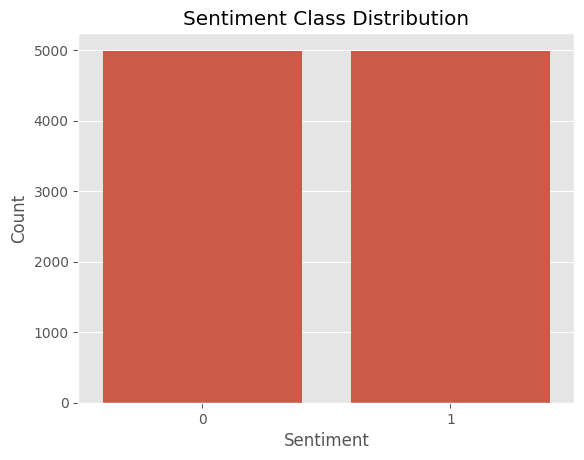

In [11]:
print("Class distribution:")
print(df['label'].value_counts())

# Visualize class distribution
sns.countplot(x='label', data=df)
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

The dataset is balanced, so we don't need to worry about class imbalance.

### Analyzing Review Lengths


Review Length Statistics:
count    9984.000000
mean      228.948317
std       168.330847
min         6.000000
25%       126.000000
50%       173.000000
75%       274.000000
max      1196.000000
Name: review_length, dtype: float64


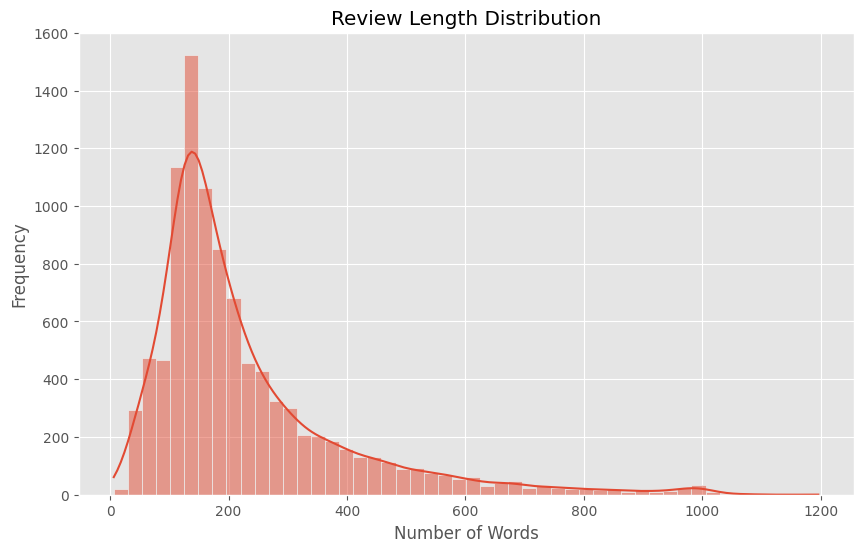

In [12]:
# Calculate review lengths (number of words)
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Basic statistics of review lengths
print("\nReview Length Statistics:")
print(df['review_length'].describe())

# Visualize review length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Review Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


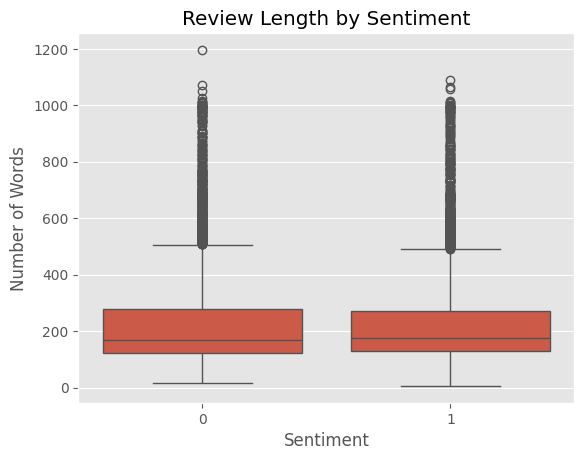

In [13]:
# Boxplot of review length by sentiment
sns.boxplot(x='label', y='review_length', data=df)
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')
os.makedirs('../results/eda', exist_ok=True)
plt.savefig('../results/eda/review_length_by_sentiment.png', bbox_inches='tight')
plt.show()

There is no big difference in review lengths by sentiment, so we don't need to worry about it while splitting.

# Lexical Analysis (Most Common Words)

In [14]:
# Function to preprocess text
def preprocess_text(text):
    """
    Function to preprocess text data
    """
    
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing
df['tokens'] = df['review'].apply(preprocess_text)

In [15]:
type(df['label'][0])

numpy.int64

# Most Common Words in Positive and Negative Reviews

In [16]:
# Separate positive and negative reviews
positive_reviews = df[df['label'] == 0]
negative_reviews = df[df['label'] == 1]

# Get all tokens for each class
positive_tokens = [token for tokens in positive_reviews['tokens'] for token in tokens]
negative_tokens = [token for tokens in negative_reviews['tokens'] for token in tokens]

# Get most common words
positive_counter = Counter(positive_tokens)
negative_counter = Counter(negative_tokens)

print("\nMost common words in positive reviews:")
print(positive_counter.most_common(20))

print("\nMost common words in negative reviews:")
print(negative_counter.most_common(20))



Most common words in positive reviews:
[('br', 10889), ('film', 7539), ('movie', 7228), ('one', 4964), ('like', 3312), ('good', 2851), ('story', 2452), ('great', 2449), ('see', 2332), ('time', 2315), ('well', 2202), ('really', 2157), ('also', 2049), ('would', 2040), ('even', 1931), ('much', 1799), ('first', 1767), ('love', 1736), ('people', 1656), ('films', 1655)]

Most common words in negative reviews:
[('br', 11679), ('movie', 9271), ('film', 7080), ('one', 5005), ('like', 4441), ('even', 3013), ('bad', 2829), ('good', 2814), ('would', 2661), ('really', 2459), ('time', 2256), ('see', 2061), ('dont', 1980), ('much', 1973), ('get', 1926), ('story', 1910), ('people', 1862), ('make', 1820), ('could', 1694), ('made', 1692)]


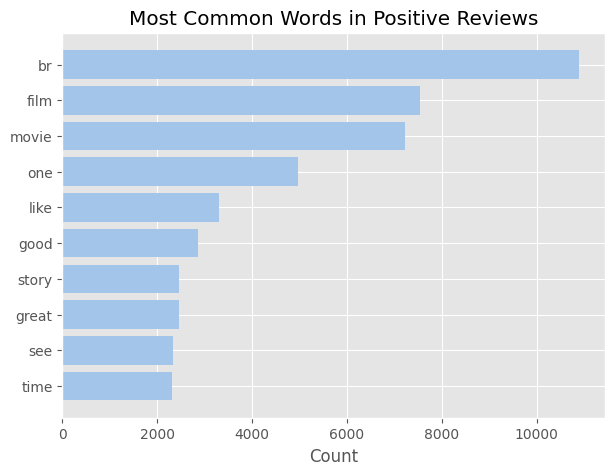

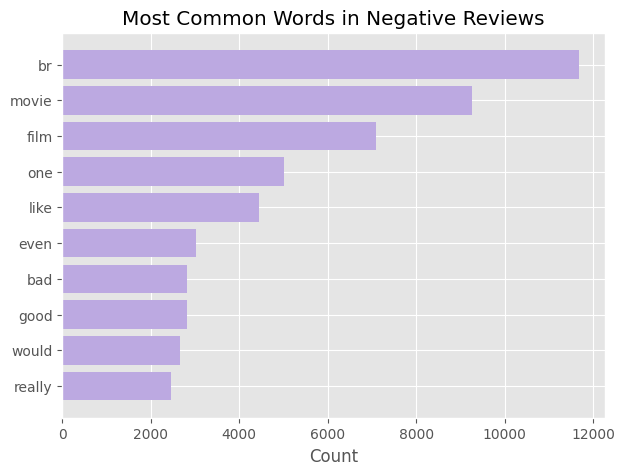

In [17]:
N = 10
# Get the N most common words for positive and negative reviews
positive_common_words = positive_counter.most_common(N)
negative_common_words = negative_counter.most_common(N)

# Separate words and their counts for positive and negative reviews
positive_words, positive_counts = zip(*positive_common_words)
negative_words, negative_counts = zip(*negative_common_words)

# Plot for positive words
plt.figure(figsize=(7, 5))
plt.barh(positive_words, positive_counts, color='#a4c5ea')
plt.xlabel('Count')
plt.title('Most Common Words in Positive Reviews')
plt.gca().invert_yaxis()
plt.savefig('../results/eda/most_common_words_in_positive_reviews.png', bbox_inches='tight')
plt.show()

# Plot for negative words
plt.figure(figsize=(7, 5))
plt.barh(negative_words, negative_counts, color='#bca9e1')
plt.xlabel('Count')
plt.title('Most Common Words in Negative Reviews')
plt.gca().invert_yaxis()
plt.savefig('../results/eda/most_common_words_in_negative_reviews.png', bbox_inches='tight')
plt.show()


# Visualizing Word Clouds

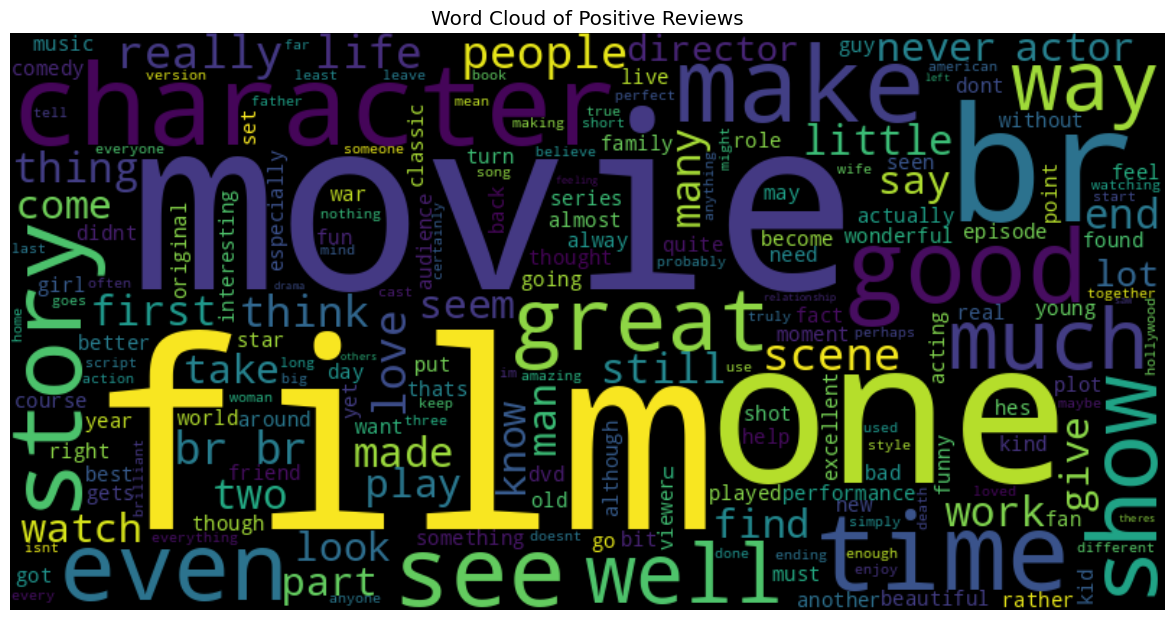

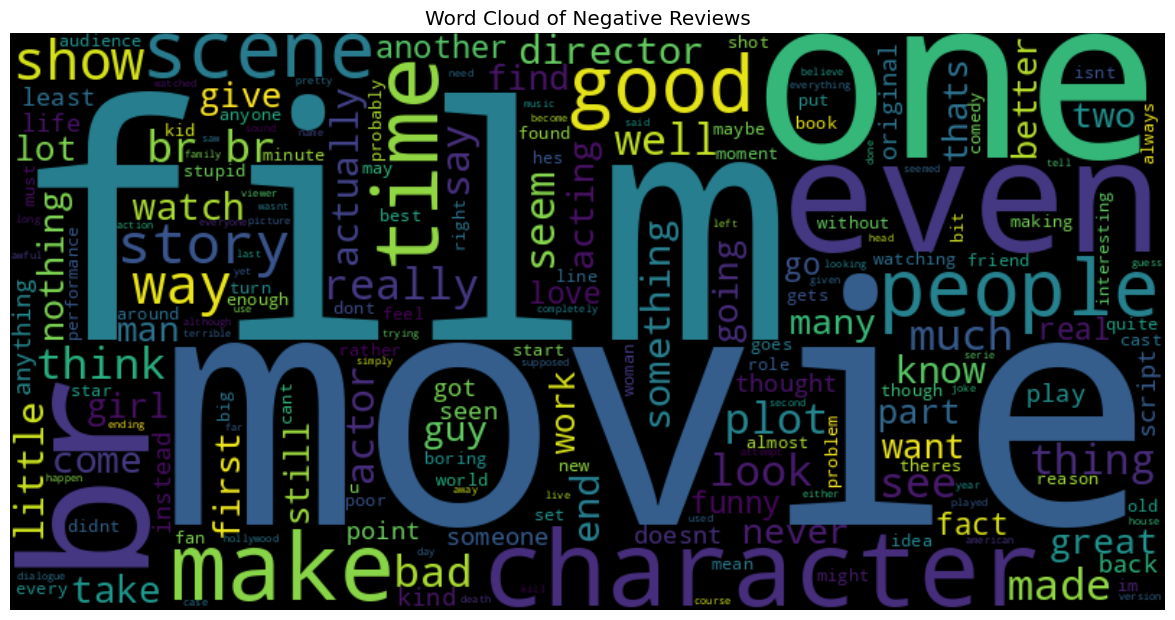

In [18]:
# Generate word cloud for positive reviews
positive_text = ' '.join(positive_tokens)
positive_wordcloud = WordCloud(width=800, height=400).generate(positive_text)

plt.figure(figsize=(15, 7.5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews')
plt.savefig('../results/eda/wordcloud_for_positive_tokens.png', bbox_inches='tight')
plt.show()

# Generate word cloud for negative reviews
negative_text = ' '.join(negative_tokens)
negative_wordcloud = WordCloud(width=800, height=400).generate(negative_text)

plt.figure(figsize=(15, 7.5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Reviews')
plt.savefig('../results/eda/wordcloud_for_negative_tokens.png', bbox_inches='tight')
plt.show()


# Conclusions:

1. The dataset is balanced, so we don't need to worry about class imbalance.
2. There are no missing values in the dataset.
3. There are only 16 duplicates in the dataset, so it will not significantly affect any metrics.
4. There is no big difference in review lengths by sentiment, so we don't need to worry about it while splitting.
5. The most common words in positive and negative reviews are pretty similar, so we need to be careful
6. There are some unique words in positive and negative reviews, so it is possible to use encoding models to create embeddings for them and train a simple logreg model to predict sentiment - it can be a good baseline model.
7. There are some html tags in the reviews, so we need to remove them before training models.
